## https://timholy.github.io/Revise.jl/stable/
## https://github.com/fonsp/Pluto.jl

# Flux and Torch.jl

# Neural ODEs Cartpole Blog Post
- https://medium.com/swlh/neural-ode-for-reinforcement-learning-and-nonlinear-optimal-control-cartpole-problem-revisited-5408018b8d71
- https://diffeqflux.sciml.ai/stable/examples/neural_ode_sciml/
- https://github.com/samuela/ctpg/blob/main/pendulum/pendulum_unconstrained.jl
- https://github.com/samuela/ctpg/blob/main/pendulum/pendulum.jl

In [3]:
using DiffEqFlux,
    DifferentialEquations,
    Flux,
    Plots,
    Interpolations,
    DataFrames,
    CSV,
    JSON,
    Plots,
    Dates,
    Dierckx,
    FiniteDifferences,
    Optim

In [4]:
# physical params
m = 1 # pole mass kg
M = 2 # cart mass kg
L = 1 # pole length m
g = 9.8 # acceleration constant m/s^2

9.8

In [5]:
# map angle to [-pi, pi)
modpi(theta) = mod2pi(theta + pi) - pi

modpi (generic function with 1 method)

In [6]:
#=
system dynamics derivative
du: du/dt, state vector derivative updated inplace
u: state vector (x, dx, theta, dtheta)
p: parameter function, here lateral force exerted by cart as a fn of time
t: time
=#
function cartpole(du, u, p, t)
  # position (cart), velocity, pole angle, angular velocity
  x, dx, theta, dtheta = u
  force = p(t)

  du[1] = dx
  du[2] =
    (force + m * sin(theta) * (L * dtheta^2 - g * cos(theta))) /
    (M + m * sin(theta)^2)
  du[3] = dtheta
  du[4] =
    (
      -force * cos(theta) - m * L * dtheta^2 * sin(theta) * cos(theta) +
      (M + m) * g * sin(theta)
    ) / (L * (M + m * sin(theta)^2))
end

cartpole (generic function with 1 method)

In [7]:
# neural network controller, here a simple MLP
# inputs: cos(theta), sin(theta) [to avoid discontinuity in theta mod 2pi], theta_dot
# output: cart force
controller = FastChain((x, p) -> x, FastDense(3, 8, tanh), FastDense(8, 1))

# initial neural network weights
pinit = initial_params(controller)

41-element Vector{Float32}:
  0.38503554
  0.16024522
 -0.33653522
  0.28588787
  0.23297945
  0.3066506
  0.026783224
  0.6611765
  0.31154892
 -0.3055295
  0.46562874
  0.07022151
  0.10957289
  ⋮
  0.0
  0.0
  0.0
 -0.5993568
 -0.05184514
 -0.13311006
 -0.026147412
  0.059859816
  0.3992346
 -0.0594734
 -0.33364686
  0.0

In [8]:
#=
system dynamics derivative with the controller included
=#
function cartpole_controlled(du, u, p, t)
  # controller force response
  force = controller([cos(u[3]), sin(u[3]), u[4]], p)[1]
  du[5] = force

  # plug force into system dynamics
  cartpole(du, u[1:4], t -> force, t)
end

# initial condition
u0 = [0; 0; pi; 0; 0]
tspan = (0.0, 1.0)
N = 50
tsteps = range(tspan[1], length = N, tspan[2])
dt = (tspan[2] - tspan[1]) / N

0.02

In [9]:
# set up ODE problem
prob = ODEProblem(cartpole_controlled, u0, tspan, pinit)

# wrangles output from ODE solver
function format(pred)
  x = pred[1, :]
  dx = pred[2, :]

  theta = modpi.(pred[3, :])
  dtheta = pred[4, :]

  # take derivative of impulse to get force
  impulse = pred[5, :]
  tmp = (impulse .- circshift(impulse, 1)) / dt
  force = [tmp[2], tmp[2:end]...]

  return x, dx, theta, dtheta, force
end

# solves ODE
function predict_neuralode(p)
  tmp_prob = remake(prob, p = p)
  solve(tmp_prob, Tsit5(), saveat = tsteps)
end

# loss to minimize as a function of neural network parameters p
function loss_neuralode(p)
  pred = predict_neuralode(p)
  x, dx, theta, dtheta, force = format(pred)
  loss = sum(theta .^ 2) / N + 4theta[end]^2 + dx[end]^2

  return loss, pred
end

loss_neuralode (generic function with 1 method)

In [10]:
i = 0 # training epoch counter
data = 0 # time series of state vector and control signal
# callback function after each training epoch
callback = function (p, l, pred; doplot = true)
  global i += 1

  global data = format(pred)
  x, dx, theta, dtheta, force = data

  # ouput every few epochs
  if i % 50 == 0
    println(l)
    display(plot(tsteps, theta))
    display(plot(tsteps, x))
    display(plot(tsteps, force))
  end

  return false
end

#5 (generic function with 1 method)

In [11]:
@time result = DiffEqFlux.sciml_train(
  loss_neuralode,
  pinit,
  ADAM(0.05),
  cb = callback,
  maxiters = 1500,
)

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\mretc\.julia\packages\OrdinaryDiffEq\PIjOZ\src\initdt.jl:95
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\mretc\.julia\packages\OrdinaryDiffEq\PIjOZ\src\solve.jl:510
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase C:\Users\mretc\.julia\packages\SciMLBase\cA7Re\src\integrator_interface.jl:325


LoadError: BoundsError: attempt to access 1-element Vector{Float64} at index [2]

In [24]:
p = result.minimizer

41-element Vector{Float32}:
  -0.8574589
   0.8331218
   0.8108274
  -0.84997964
  -0.9035626
  -3.5197735
   0.90991974
   0.91420865
  -7.6220403
   8.045365
   8.4820595
  -7.777374
  -6.9170165
   ⋮
  -0.9647031
  -1.3092359
  -1.3248439
  -9.625703
   9.896537
  10.165344
  -9.604855
 -11.804577
 -10.786395
  11.531343
  11.098292
  -8.078428

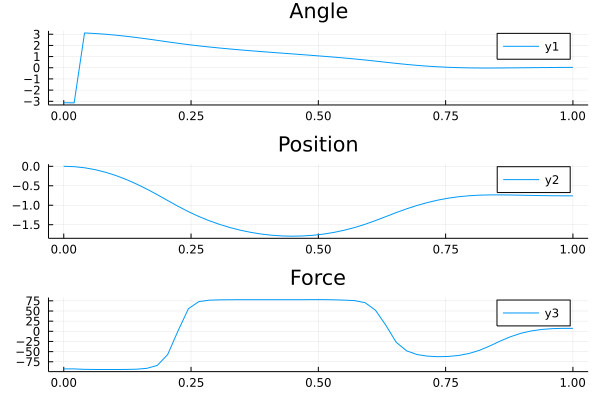

┌ Info: Saved animation to 
│   fn = C:\Users\mretc\OneDrive\Documents\Grad School\thesis\cartpole\cartpole_animation.gif
└ @ Plots C:\Users\mretc\.julia\packages\Plots\Awg62\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\mretc\\OneDrive\\Documents\\Grad School\\thesis\\cartpole\\cartpole_animation.gif")
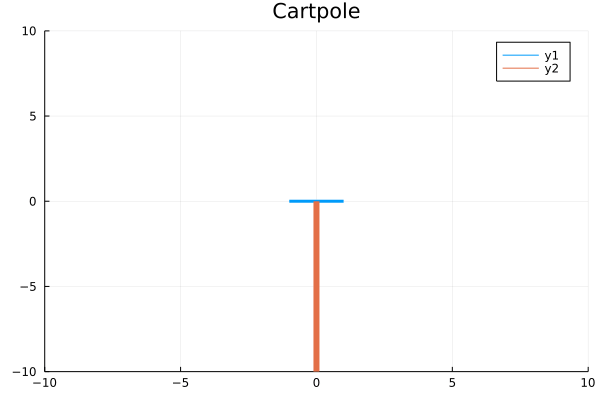

In [25]:
# save model and data
open(io -> write(io, json(p)), "model.json", "w")
open(io -> write(io, json(data)), "data.json", "w")

gr()
x, dx, theta, dtheta, force = data
anim = Animation()

plt=plot(tsteps,[modpi.(theta.+.01),x,force],title=["Angle" "Position" "Force"],layout=(3,1))
display(plt)
savefig(plt,"cartpole_data.png")

for (x, theta) in zip(x, theta)
    cart = [x - 1 x + 1; 0 0]
    pole = [x x + 10*sin(theta); 0 10*cos(theta)]
    plt = plot(
        cart[1, :],
        cart[2, :],
        xlim = (-10, 10),
        ylim = (-10, 10),
        title = "Cartpole",
        linewidth = 3,
    )
    plot!(plt, pole[1, :], pole[2, :], linewidth = 6)

    frame(anim)
end

gif(anim, "cartpole_animation.gif", fps = 10)

# Trying to understand the NaN problem
- This didn't help me get anywhere with debugging... ugh
- https://diffeq.sciml.ai/stable/basics/integrator/

In [85]:
tmp_prob = remake(prob, p = p)
# solve(tmp_prob, Tsit5(), saveat = tsteps)
integrator = init(tmp_prob, Tsit5())
step!(integrator)